In [ ]:
suppressMessages(require(ggplot2))
suppressMessages(require(data.table))
suppressMessages(require(gplots))
suppressMessages(require(Seurat))
suppressMessages(require(Matrix))
source("VDJ_ploting_suite.R")
source("VDJ_function_pack.R")
suppressMessages(require(xlsx))
suppressMessages(require(ggplot2))
suppressMessages(require(reshape))
suppressMessages(require(scales))

load("180607_VDJinfo.Rdata")
load("180607_misc.Rdata")
base_Rdata_name="180607_RUVscale"

In [2]:
Exp_Seurat=readRDS(file="Exp_Seurat_Tcell.Rds")
#load("abgdTcell_labeling.Rdata")
tag_celltype="Tcell"

#cell type assignment
Tcell_assignment_df=data.frame(cluster=c("12,9,5,15","6,16","11","1,0,10,7","14","4,17,3,8,2,13"),
                                  celltype=c("CD8_TEM_effector","CD8","CD8_TCM","NKT","gdT","CD4"),
                                  stringsAsFactors=F)
Tcell_assignment_df=data.frame(cluster=c("12,9,5,15,6,16,11","1,0,10,7","14","4,17,3,8,2,13"),
                                  celltype=c("CD8","NKT","gdT","CD4"),
                                  stringsAsFactors=F)
Tcell_assignment_expanded=cellTypeDF_processing(Tcell_assignment_df)
Tcell_assignment=gp_name_replacing(as.character(Exp_Seurat@ident),Tcell_assignment_expanded$cluster,Tcell_assignment_expanded$celltype)
Tcellsubcelltype_assignment=gp_name_replacing(as.character(Exp_Seurat@ident),Tcell_assignment_expanded$cluster,Tcell_assignment_expanded$subcelltype)

In [3]:
#select target annotation
tag_annotation=TCR_annoation[which(TCR_annoation$is_cell & TCR_annoation$high_confidence & TCR_annoation$productive),] 
tag_annotation=tag_annotation[!(tag_annotation$chain %in% c("Multi","TRD","TRG")),]
#tag_annotation=rbind(TCR_annoation,TCR_annoation_w)
format(object.size(tag_annotation),units="Mb")

[1] "108.3 Mb"

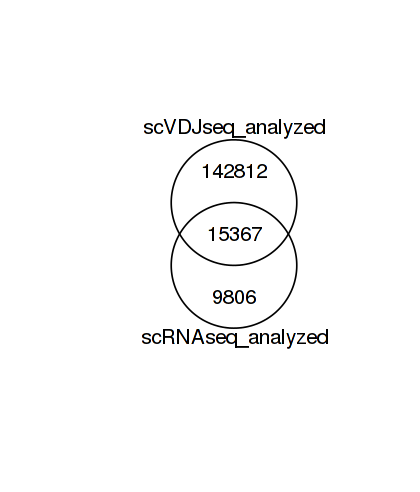

In [4]:
options(repr.plot.width=3.5, repr.plot.height=4.1)
venn(list(scRNAseq_analyzed=colnames(Exp_Seurat@data),scVDJseq_analyzed=unique(tag_annotation$barcode)),small=0.5)

###   make cell-VDJC matrix

In [20]:
batch_info=data.frame(batch=sample_list,
                      patient_id=gsub("_.*","",sample_list),
                      tissue_type=gsub(".*_","",sample_list),
                      disease_status=substring(sample_list, 1, 1))

all_barcode=unique(tag_annotation$barcode)
all_v=unique(tag_annotation$v_gene)
all_d=unique(tag_annotation$d_gene)
all_j=unique(tag_annotation$j_gene)
all_c=unique(tag_annotation$c_gene)

position_index_matrix=matrix(0,nrow(tag_annotation),14)
colnames(position_index_matrix)=c("barcode","v_gene","d_gene","j_gene","c_gene","cdr3","cdr3_nt","celltype","batch_id","tissue_type","patient_id","disease","clone_id","expand_lvl") #
position_index_matrix=data.frame(position_index_matrix)
position_index_matrix$barcode=tag_annotation$barcode #match(tag_annotation$barcode,all_barcode)
position_index_matrix$v_gene=tag_annotation$v_gene #match(tag_annotation$v_gene,all_v)
position_index_matrix$d_gene=tag_annotation$d_gene #match(tag_annotation$d_gene,all_d)
position_index_matrix$j_gene=tag_annotation$j_gene #match(tag_annotation$j_gene,all_j)
position_index_matrix$c_gene=tag_annotation$c_gene #match(tag_annotation$c_gene,all_c)
position_index_matrix$cdr3=tag_annotation$cdr3
position_index_matrix$cdr3_nt=tag_annotation$cdr3_nt

position_index_matrix$celltype=Tcellsubcelltype_assignment[match(tag_annotation$barcode,colnames(Exp_Seurat@data))]

tmp=strsplit(tag_annotation$barcode, "-")
batch_belonging=as.numeric(lapply(tmp,function(x){return(x[2])}))
position_index_matrix$batch_id=sample_list[batch_belonging]

patients=unique(gsub("_.*","",sample_list))
for(i in 1:length(patients)){
    position_index_matrix$patient_id[batch_belonging %in% grep(patients[i],sample_list)]=patients[i]
}

tissues=c("pBMC","I","R")
for(i in 1:length(tissues)){
    position_index_matrix$tissue_type[batch_belonging %in% grep(tissues[i],sample_list)]=tissues[i]
}

position_index_matrix$disease="healthy"
position_index_matrix$disease[grep("U",position_index_matrix$patient_id)]="ill"

#filter problematic rows
position_index_matrix=position_index_matrix[!position_index_matrix$batch_id %in% c("C19_pBMC","C19_I"),] #C19 I and P have problem
batch_info=batch_info[batch_info$batch %in% unique(position_index_matrix$batch_id),]

#clonetype
clone_type=paste0(position_index_matrix$v_idx,"_",position_index_matrix$d_idx,"_",position_index_matrix$j_idx,"_",position_index_matrix$cdr3_nt)

for(i in 1:length(patients)){
    tag_posi=which(position_index_matrix$patient_id==patients[i])
    tag_clone_types=clone_type[tag_posi]
    position_index_matrix$clone_id[tag_posi]=paste0(patients[i],"_clone_",as.numeric(as.factor(tag_clone_types)))
}

#expansion_level
exp_lvl=table(position_index_matrix$clone_id)
position_index_matrix$expand_lvl=exp_lvl[match(position_index_matrix$clone_id,names(exp_lvl))]

saveRDS(position_index_matrix,file="T_cell_position_index_matrix.rds")

#### VDJC gene usage

In [24]:
source("VDJ_function_pack.R")
plot_usage(position_index_matrix,tag_col="v_gene",out_name="T cell v_gene usage.pdf",out_height=12,out_width=35,
          lhei=c(0.8,5),lwid=c(0.5,5),margins=c(10,12),notecex=0.75,colorby="row")
plot_usage(position_index_matrix,tag_col="d_gene",out_name="T cell d_gene usage.pdf",out_height=12,out_width=5,
          lhei=c(0.8,5),lwid=c(2,5),margins=c(14,10),notecex=0.75,colorby="row")
plot_usage(position_index_matrix,tag_col="j_gene",out_name="T cell j_gene usage.pdf",out_height=12,out_width=35,
          lhei=c(0.8,5),lwid=c(0.5,5),margins=c(10,12),notecex=0.75,colorby="row")
plot_usage(position_index_matrix,tag_col="c_gene",out_name="T cell c_gene usage.pdf",out_height=12,out_width=5,
          lhei=c(0.8,5),lwid=c(2,5),margins=c(14,10),notecex=0.75,colorby="row")
plot_usage(position_index_matrix,tag_col="expand_lvl",out_name="T cell expand_lvl distribution.pdf",out_height=12,out_width=35,
          lhei=c(0.8,5),lwid=c(0.5,5),margins=c(5,12),notecex=0.75,Colv=F,Rowv=T,colorby="row")

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

In [12]:
TRAs=position_index_matrix[position_index_matrix$c_gene=="TRAC",]
table(TRAs$d_gene,useNA = "ifany")

TRB1s=position_index_matrix[position_index_matrix$c_gene=="TRBC1",]
table(TRB1s$d_gene,useNA = "ifany")

TRB2s=position_index_matrix[position_index_matrix$c_gene=="TRBC2",]
table(TRB2s$d_gene,useNA = "ifany")


  <NA> 
127426 


TRBD1 TRBD2  <NA> 
34862 13644 15771 


TRBD1 TRBD2  <NA> 
32609 36830 19393 

### analysis on MAIT (TRAV1-2_TRAJ33_TRAC)

In [29]:
tag=which(position_index_matrix$celltype=="CD8_TEM_effector_4" & position_index_matrix$v_gene=="TRAV1-2" & position_index_matrix$j_gene=="TRAJ33" & position_index_matrix$c_gene=="TRAC")
a1=table(position_index_matrix$tissue_type[tag])
a2=table(position_index_matrix$tissue_type[!is.na(position_index_matrix$celltype)])
a2=a2[match(names(a1),names(a2))]
a1=rbind(count=a1,percentage=paste0(round(a1/a2*100,2),"%"))
rownames(a1)[is.na(rownames(a1))]="NA"
#write.xlsx(data.frame(a1), file=paste0(V_id,"_",J_id,"_",C_id,"_stats.xlsx"), sheetName="celltype", append=F, row.names=T,showNA = T)
a1

a1=table(position_index_matrix$patient_id[tag])
a2=table(position_index_matrix$patient_id[!is.na(position_index_matrix$celltype)])
a2=a2[match(names(a1),names(a2))]
a1=rbind(count=a1,percentage=paste0(round(a1/a2*100,2),"%"))
rownames(a1)[is.na(rownames(a1))]="NA"
#write.xlsx(data.frame(a1), file=paste0(V_id,"_",J_id,"_",C_id,"_stats.xlsx"), sheetName="celltype", append=F, row.names=T,showNA = T)
a1

,I,pBMC,R
count,9,108,28
percentage,0.29%,0.85%,0.24%


,C12,C16,C17,C18,C19,C21,C30,C33,C9,U3,U34,U35,U4,U41,U44,U45,U5
count,26,1,21,2,1,1,25,14,2,10,3,9,1,15,9,1,4
percentage,2.19%,0.04%,1.21%,0.13%,0.13%,0.07%,1.1%,0.95%,0.45%,0.5%,0.22%,0.51%,0.05%,0.81%,0.43%,0.06%,0.29%


In [48]:
tag=which(position_index_matrix$celltype=="CD8_TEM_effector_4" ) #& position_index_matrix$v_gene=="TRAV1-2" & position_index_matrix$j_gene=="TRAJ33" & position_index_matrix$c_gene=="TRAC"

a1=table(position_index_matrix$batch_id[tag])
a2=table(position_index_matrix$batch_id[!is.na(position_index_matrix$celltype)])
a2=a2[match(names(a1),names(a2))]

tag=which(position_index_matrix$celltype=="CD8_TEM_effector_4" &position_index_matrix$v_gene=="TRAV1-2" & position_index_matrix$j_gene=="TRAJ33" & position_index_matrix$c_gene=="TRAC") #
b1=table(position_index_matrix$batch_id[tag])
b1=b1[match(names(a1),names(b1))]
b1[is.na(b1)]=0

plot_table=rbind(data.table(count=as.numeric(a1),
                            percentage=as.numeric(round(a1/a2*100,2)),
                            tissue=gsub("^.*_","",names(a1)),
                            patient=gsub("_.*","",names(a1)),
                            tag="CD8_4"),
                 data.table(count=as.numeric(b1),
                            percentage=as.numeric(round(b1/a2*100,2)),
                            tissue=gsub("^.*_","",names(a1)),
                            patient=gsub("_.*","",names(a1)),
                            tag="CD8_4 TRAV1-2/TRAJ33/TRAC")
                 )

plot_table=data.frame(melt(plot_table, id.vars = c("tissue","patient","tag"),measure.vars = c("percentage")))
plot_table$value=as.numeric(plot_table$value)

#options(repr.plot.width=13, repr.plot.height=4)
pdf("MAIT abundance.pdf",width=13,height=4)
ggplot(plot_table, aes(x=patient,y=value)) +
    geom_bar(aes(fill = tag), position = "dodge", stat="identity") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
    labs(x = "patient", y= "percentage") +
    facet_wrap(~tissue, nrow = 1, scales = "free") #facet_grid(~tissue,scales="free", space="free_x")
dev.off()

png 
  2

In [46]:
source("VDJ_function_pack.R")
VJC_stats(position_index_matrix,V_id = "TRAV1-2",J_id = "TRAJ33",C_id = "TRAC",batch_info=batch_info)

In [59]:
tag=which(position_index_matrix$celltype=="CD8_TEM_effector_4" & position_index_matrix$v_gene=="TRAV1-2" &
          position_index_matrix$j_gene=="TRAJ33" & position_index_matrix$c_gene=="TRAC")
tmp=table(position_index_matrix[tag,"clone_id"])
tmp=table(tmp)
plot_table=data.frame(groups=paste0("TRAV1-2_TRAJ33_TRAC_all\n",round(sum(tmp[as.numeric(names(tmp))>1])/sum(tmp),2)*100,"% expanded"),
                      expansion_level=names(tmp),
                      clonetype_number=as.numeric(tmp),stringsAsFactors =F)

tag=which(position_index_matrix$celltype=="CD8_TEM_effector_4" & position_index_matrix$v_gene=="TRAV1-2" &
          position_index_matrix$j_gene=="TRAJ33" & position_index_matrix$c_gene=="TRAC" & position_index_matrix$disease=="healthy")
tmp=table(position_index_matrix[tag,"clone_id"])
tmp=table(tmp)
plot_table1=data.frame(groups=paste0("TRAV1-2_TRAJ33_TRAC_healthy\n",round(sum(tmp[as.numeric(names(tmp))>1])/sum(tmp),2)*100,"% expanded"),
                      expansion_level=names(tmp),
                      clonetype_number=as.numeric(tmp),stringsAsFactors =F)

tag=which(position_index_matrix$celltype=="CD8_TEM_effector_4" & position_index_matrix$v_gene=="TRAV1-2" &
          position_index_matrix$j_gene=="TRAJ33" & position_index_matrix$c_gene=="TRAC" & position_index_matrix$disease=="ill")
tmp=table(position_index_matrix[tag,"clone_id"])
tmp=table(tmp)
plot_table2=data.frame(groups=paste0("TRAV1-2_TRAJ33_TRAC_ill\n",round(sum(tmp[as.numeric(names(tmp))>1])/sum(tmp),2)*100,"% expanded"),
                      expansion_level=names(tmp),
                      clonetype_number=as.numeric(tmp),stringsAsFactors =F)




tmp=table(position_index_matrix[!is.na(position_index_matrix$celltype),"clone_id"])
tmp=table(tmp)
plot_table3=data.frame(groups=paste0("all\n",round(sum(tmp[as.numeric(names(tmp))>1])/sum(tmp),2)*100,"% expanded"),
                      expansion_level=names(tmp),
                      clonetype_number=as.numeric(tmp),stringsAsFactors =F)



plot_table=rbind(plot_table,plot_table1,plot_table2,plot_table3)

#options(repr.plot.width=7, repr.plot.height=4)
pdf("TRAV1-2_TRAJ33_TRAC clontype expansion barplot.pdf",width=14.5,height=4)
ggplot(plot_table, aes(x=factor(expansion_level,levels=unique(expansion_level)),y=clonetype_number)) +
    geom_bar(stat="identity") +
    theme_minimal() + theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
    labs(x = "expansion level", y= "number of clone type") +
    facet_wrap(~groups, nrow = 1, scales = "free")
dev.off()

png 
  2

In [7]:
tag=which(position_index_matrix$celltype=="CD8_TEM_effector_4" & position_index_matrix$v_gene=="TRAV1-2" &
          position_index_matrix$j_gene=="TRAJ33" & position_index_matrix$c_gene=="TRAC")
tag=position_index_matrix[tag,"barcode"]
MAIT_TRBs=position_index_matrix[position_index_matrix$barcode %in% tag & position_index_matrix$c_gene != "TRAC",]

In [10]:
table(MAIT_TRBs$v_gene,useNA = "ifany")
table(MAIT_TRBs$d_gene,useNA = "ifany")
table(MAIT_TRBs$j_gene,useNA = "ifany")
table(MAIT_TRBs$c_gene,useNA = "ifany")



TRBV10-1 TRBV10-2 TRBV12-4   TRBV15    TRBV2 TRBV20-1 TRBV25-1   TRBV27 
       1        1        1        5        1       25        1        1 
  TRBV28 TRBV29-1   TRBV30  TRBV3-1  TRBV4-2  TRBV4-3  TRBV5-1  TRBV6-1 
       4        1        3        3       10        7        2       19 
 TRBV6-3  TRBV6-4  TRBV6-5  TRBV7-2  TRBV7-8 
      10       26        7        1        1 


TRBD1 TRBD2  <NA> 
   43    73    14 


TRBJ1-1 TRBJ1-2 TRBJ1-3 TRBJ1-5 TRBJ1-6 TRBJ2-1 TRBJ2-2 TRBJ2-3 TRBJ2-4 TRBJ2-5 
      7       1       4       5       1      37      17      20       2      12 
TRBJ2-6 TRBJ2-7 
      3      21 


TRBC1 TRBC2 
   23   107 

### what VJC are enriched in disease and healthy

In [48]:
tmp=table(position_index_matrix$batch_id,paste0(position_index_matrix$v_gene,"_",position_index_matrix$j_gene,"_",position_index_matrix$c_gene))
batch_total=table(position_index_matrix$batch_id[!duplicated(position_index_matrix$barcode)])
batch_total=batch_total[match(rownames(tmp),names(batch_total))]
tmp=apply(tmp,2,function(x){x/batch_total})
tmp=cbind(gsub("_.*","",rownames(tmp)),data.frame(tmp))
colnames(tmp)[1]="patient_id"
tmp=data.table(tmp)
tmp=tmp[,lapply(.SD, mean),by=patient_id]

tmp2=tmp
tmp2$patient_id=substring(tmp2$patient_id, 1, 1)
colnames(tmp2)[1]="disease_status"
tmp2=tmp2[,lapply(.SD, mean),by=disease_status]
tmp2=data.frame(tmp2)
rownames(tmp2)=tmp2$disease_status
tmp2$disease_status=NULL
tmp2=as.matrix(tmp2)
tmp=data.frame(tmp)

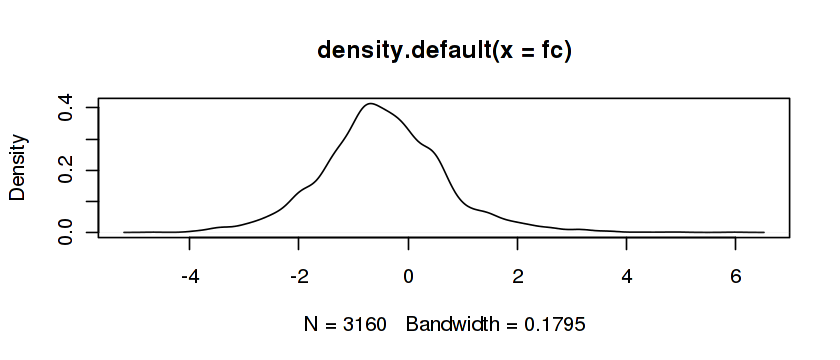

In [49]:
fc=log2((tmp2[1,]+10^-5)/(tmp2[2,]+10^-5))
options(repr.plot.width=7, repr.plot.height=3)
plot(density(fc))

In [62]:
#enrich in IBD
source("VDJ_function_pack.R")
singlepatient_max=0.5
log2foldchange_threshold=1
min_cellnum=100
tag=which(fc<=(-log2foldchange_threshold))
tag_VJC_df=data.frame(do.call(rbind,strsplit(colnames(tmp2)[tag],"_")))
colnames(tag_VJC_df)=c("V_id","J_id","C_id")
tag_VJC_df$V_id=gsub("\\.","-",tag_VJC_df$V_id)
to_keep=c()

for(i in 1:nrow(tag_VJC_df)){
    tag=which(position_index_matrix$v_gene==tag_VJC_df$V_id[i] & position_index_matrix$j_gene==tag_VJC_df$J_id[i] & position_index_matrix$c_gene==tag_VJC_df$C_id[i])
    if(length(unique(position_index_matrix$barcode)[tag])<min_cellnum){
        next
    }
    e1=table(position_index_matrix$patient_id[tag],useNA="i")
    if(max(e1)/sum(e1)<singlepatient_max){
        to_keep=c(to_keep,i)
        VJC_stats(position_index_matrix,V_id = tag_VJC_df$V_id[i],J_id = tag_VJC_df$J_id[i],C_id = tag_VJC_df$C_id[i],batch_info=batch_info)
    } 
}
tag_VJC_df=tag_VJC_df[to_keep,]
message(paste0(nrow(tag_VJC_df)," VJC combination passed filter"))
if(nrow(tag_VJC_df)>0){write.xlsx(data.frame(tag_VJC_df), file="VJC combination enriched in disease.xlsx", append=F, row.names=F)}


83 VJC combination passed filter


In [71]:
table(tag_VJC_df$V_id)#[table(tag_VJC_df$V_id)>1]
table(tag_VJC_df$J_id)[table(tag_VJC_df$J_id)>0]
table(tag_VJC_df$C_id)


    TRAV1-2    TRAV12-1    TRAV12-2    TRAV12-3    TRAV13-1    TRAV13-2 
          1           8           6           3           2           3 
  TRAV14DV4      TRAV17      TRAV19       TRAV2      TRAV21   TRAV23DV6 
          7           7           1           1           2           1 
   TRAV26-1    TRAV26-2      TRAV27   TRAV29DV5       TRAV3    TRAV38-1 
         10           2           3           1           4           2 
TRAV38-2DV8       TRAV4     TRAV8-3     TRAV8-4     TRAV9-2 
          2           1           4           4           8 


TRAJ10 TRAJ13 TRAJ15 TRAJ17 TRAJ20 TRAJ21 TRAJ22 TRAJ23 TRAJ26 TRAJ27 TRAJ28 
     3      1      2      1      4      1      1      2      2      2      2 
TRAJ29 TRAJ30 TRAJ31 TRAJ33 TRAJ34 TRAJ36 TRAJ37 TRAJ39  TRAJ4 TRAJ40 TRAJ42 
     2      1      1      2      2      1      1      5      3      2      2 
TRAJ43 TRAJ44 TRAJ45 TRAJ48 TRAJ49  TRAJ5 TRAJ52 TRAJ53 TRAJ54 TRAJ57  TRAJ6 
     3      1      3      3      6      2      4      5      2      3      3 
 TRAJ8  TRAJ9 
     2      3 


   NA  TRAC TRBC1 TRBC2 
    0    83     0     0 

In [72]:
singlepatient_max=0.5
log2foldchange_threshold=1
min_cellnum=100
tag=which(fc>=(log2foldchange_threshold))
tag_VJC_df=data.frame(do.call(rbind,strsplit(colnames(tmp2)[tag],"_")))
colnames(tag_VJC_df)=c("V_id","J_id","C_id")
tag_VJC_df$V_id=gsub("\\.","-",tag_VJC_df$V_id)
to_keep=c()

for(i in 1:nrow(tag_VJC_df)){
    tag=which(position_index_matrix$v_gene==tag_VJC_df$V_id[i] & position_index_matrix$j_gene==tag_VJC_df$J_id[i] & position_index_matrix$c_gene==tag_VJC_df$C_id[i])
    if(length(unique(position_index_matrix$barcode)[tag])<min_cellnum){
        next
    }
    e1=table(position_index_matrix$patient_id[tag],useNA="i")
    if(max(e1)/sum(e1)<singlepatient_max){
        to_keep=c(to_keep,i)
        VJC_stats(position_index_matrix,V_id = tag_VJC_df$V_id[i],J_id = tag_VJC_df$J_id[i],C_id = tag_VJC_df$C_id[i],batch_info=batch_info)
    } 
}
tag_VJC_df=tag_VJC_df[to_keep,]
message(paste0(nrow(tag_VJC_df)," VJC combination passed filter"))
if(nrow(tag_VJC_df)>0){write.xlsx(data.frame(tag_VJC_df), file="VJC combination enriched in healthy.xlsx", append=F, row.names=F)}


11 VJC combination passed filter


### clone type analysis
#### expansion per condition

In [50]:
target_condition="patient_id"
to_plot=expansion_per_condition(target_condition,position_index_matrix,plot_width=10,plot_height=4,TorB="Tcell")

target_condition="celltype"
to_plot=expansion_per_condition(target_condition,position_index_matrix,plot_width=10,plot_height=5.5,TorB="Tcell")

target_condition="batch_id"
to_plot=expansion_per_condition(target_condition,position_index_matrix,plot_width=15,plot_height=4,TorB="Tcell")

target_condition="tissue_type"
to_plot=expansion_per_condition(target_condition,position_index_matrix,plot_width=4,plot_height=4,TorB="Tcell")

#### spreading

In [21]:
#source("VDJ_function_pack.R")
spreading_info=list()
tag_patient=intersect(batch_info$patient_id[batch_info$tissue=="pBMC"],batch_info$patient_id[batch_info$tissue=="R"])
spreading_info[[1]]=spreading_cal(tag_patient,c("pBMC","R"),position_index_matrix)
names(spreading_info)[1]="pBMC vs R"

tag_patient=intersect(batch_info$patient_id[batch_info$tissue=="R"],batch_info$patient_id[batch_info$tissue=="I"])
spreading_info[[2]]=spreading_cal(tag_patient,c("I","R"),position_index_matrix)
names(spreading_info)[2]="R vs I"

tag_patient=intersect(batch_info$patient_id[batch_info$tissue=="pBMC"],batch_info$patient_id[batch_info$tissue=="I"])
spreading_info[[3]]=spreading_cal(tag_patient,c("pBMC","I"),position_index_matrix)
names(spreading_info)[3]="pBMC vs I"

tag_patient=Reduce(intersect, list(batch_info$patient_id[batch_info$tissue=="pBMC"],batch_info$patient_id[batch_info$tissue=="I"],batch_info$patient_id[batch_info$tissue=="R"])) 
spreading_info[[4]]=spreading_cal(tag_patient,c("pBMC","R","I"),position_index_matrix)
names(spreading_info)[4]="pBMC vs R vs I"

In [8]:
pdf("Tcell_clonetype_spreading.pdf",width=11,height=4.2)
#options(repr.plot.width=11, repr.plot.height=4.1)
#theplot=list()
for(i in 1:length(spreading_info)){
    theplot=ggplot() +
        geom_bar(aes(y = value, x = patient, fill = variable), data = spreading_info[[i]]$tbl_long,stat="identity",position = "fill") +
        scale_y_continuous(labels = percent_format()) +
        theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
        facet_grid( ~ tissue,scales="free_x", space="free_x") + 
        ggtitle(names(spreading_info)[i]) + labs(y = "pecentage of cells in given batch",fill='expansion type')
    print(theplot)
}
dev.off()

png 
  2

In [52]:
expansion_type_df=data.frame(pBMC_R=rep(NA,nrow(position_index_matrix)),
                             R_I=rep(NA,nrow(position_index_matrix)),
                             pBMC_I=rep(NA,nrow(position_index_matrix)),
                             pBMC_I_R=NA,stringsAsFactors=F)
for(i in 1:4){
    expansion_type_df[position_index_matrix$clone_id %in% spreading_info[[i]]$no_expansion_clones,i]="no_expansion"
    expansion_type_df[position_index_matrix$clone_id %in% spreading_info[[i]]$locally_expanded_clones,i]="local_expansion"
    expansion_type_df[position_index_matrix$clone_id %in% spreading_info[[i]]$cross_tissue_clones,i]="cross_tissue_expansion"
}

out=list()
tag_patient=intersect(batch_info$patient_id[batch_info$tissue=="pBMC"],batch_info$patient_id[batch_info$tissue=="R"])
tag_patient=setdiff(tag_patient,c("C22","C23","C10"))
tag_tissue=c("pBMC","R")
expansion_type_list=expansion_type_df$pBMC_R
out[[1]]=cell_type_distribution_in_spreading(position_index_matrix,expansion_type_list,tag_patient,tag_tissue,Tcellsubcelltype_assignment)

tag_patient=intersect(batch_info$patient_id[batch_info$tissue=="R"],batch_info$patient_id[batch_info$tissue=="I"])
tag_patient=setdiff(tag_patient,c("C22","C23","C10"))
tag_tissue=c("I","R")
expansion_type_list=expansion_type_df$R_I
out[[2]]=cell_type_distribution_in_spreading(position_index_matrix,expansion_type_list,tag_patient,tag_tissue,Tcellsubcelltype_assignment)

tag_patient=intersect(batch_info$patient_id[batch_info$tissue=="pBMC"],batch_info$patient_id[batch_info$tissue=="I"])
tag_patient=setdiff(tag_patient,c("C22","C23","C10"))
tag_tissue=c("pBMC","I")
expansion_type_list=expansion_type_df$pBMC_I
out[[3]]=cell_type_distribution_in_spreading(position_index_matrix,expansion_type_list,tag_patient,tag_tissue,Tcellsubcelltype_assignment)

tag_patient=intersect(batch_info$patient_id[batch_info$tissue=="pBMC"],batch_info$patient_id[batch_info$tissue=="I"])
tag_patient=setdiff(tag_patient,c("C22","C23","C10"))
tag_tissue=c("pBMC","I","R")
expansion_type_list=expansion_type_df$pBMC_I_R
out[[4]]=cell_type_distribution_in_spreading(position_index_matrix,expansion_type_list,tag_patient,tag_tissue,Tcellsubcelltype_assignment)

pdf("T_celltype_distribution_in_spreading.pdf",width=11,height=8)
#options(repr.plot.width=11, repr.plot.height=4.1)
for(i in 1:length(out)){
    print(out[[i]]$g)
}
dev.off()


png 
  2

In [51]:
cell_type_distribution_in_spreading=function(position_index_matrix,expansion_type_list,tag_patient,tag_tissue){
    tag_batch=cross_combining(tag_patient,tag_tissue)
    
    tmp=list()
    for(i in 1:length(tag_batch)){    
        tag=position_index_matrix$batch==tag_batch[i]
        expansion_type_cell_type_table=table(expansion_type_list[tag],position_index_matrix$celltype[tag],useNA = "ifany") #
        colnames(expansion_type_cell_type_table)[is.na(colnames(expansion_type_cell_type_table))]="unknown"
        if(sum(expansion_type_cell_type_table[,-ncol(expansion_type_cell_type_table)])==0){
            next
        }
        #expansion_type_cell_type_table[,-ncol(expansion_type_cell_type_table)]=expansion_type_cell_type_table[,-ncol(expansion_type_cell_type_table)]/sum(expansion_type_cell_type_table[,-ncol(expansion_type_cell_type_table)])
        #expansion_type_cell_type_table[,"unknown"]=expansion_type_cell_type_table[,"unknown"]/sum(expansion_type_cell_type_table)
        expansion_type_cell_type_table=expansion_type_cell_type_table[,-ncol(expansion_type_cell_type_table)]
        expansion_type_cell_type_table=expansion_type_cell_type_table/sum(expansion_type_cell_type_table)
        expansion_type_cell_type_df=as.data.frame.matrix(expansion_type_cell_type_table)
        expansion_type_cell_type_df$expansion_type=rownames(expansion_type_cell_type_df)
        expansion_type_cell_type_df=data.table(expansion_type_cell_type_df)
        expansion_type_cell_type_df= melt(expansion_type_cell_type_df, id.vars = c("expansion_type"),
                                          measure.vars = setdiff(colnames(expansion_type_cell_type_df),"expansion_type"),
                                          variable.name = "cell_type", value.name = "percent_of_patient")
        expansion_type_cell_type_df$batch=tag_batch[i]
        tmp[[i]]=expansion_type_cell_type_df
    }
    toplot=do.call(rbind,tmp)
    toplot$patient=gsub("_.*","",toplot$batch)
    toplot$tissue=gsub("^.*_","",toplot$batch)
    
    Group_type=unique(Tcellsubcelltype_assignment)
    Group_type=Group_type[gtools::mixedorder(Group_type)]    
    present_celltype=unique(toplot$cell_type)    
    coltouse=colorRampPalette(RColorBrewer::brewer.pal(9,"Set1"))(length(Tcell_assignment_expanded$subcelltype))
    coltouse=coltouse[Group_type %in% present_celltype]
    
    g=ggplot() +
            geom_bar(aes(y = percent_of_patient, x = patient, fill = factor(cell_type,levels=Group_type)), data = toplot,stat="identity",position = "stack") +
            scale_y_continuous(labels = percent_format()) +
            theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
            facet_wrap( ~ tissue + expansion_type,scales="free") + 
            ggtitle(paste(tag_tissue,collapse=" & ")) + labs(y = "pecentage of cells in given library",fill='cell type') +
            scale_fill_manual("legend", values = coltouse)
    return(list(toplot=toplot,g=g))               
}

#### map clone type to transcriptome

Warning message in plotByGroup(Exp_Seurat, Group_assignment = expansion_info_summ$expand_lvl[match(colnames(Exp_Seurat@data), :
“NAs in Group_assignment”

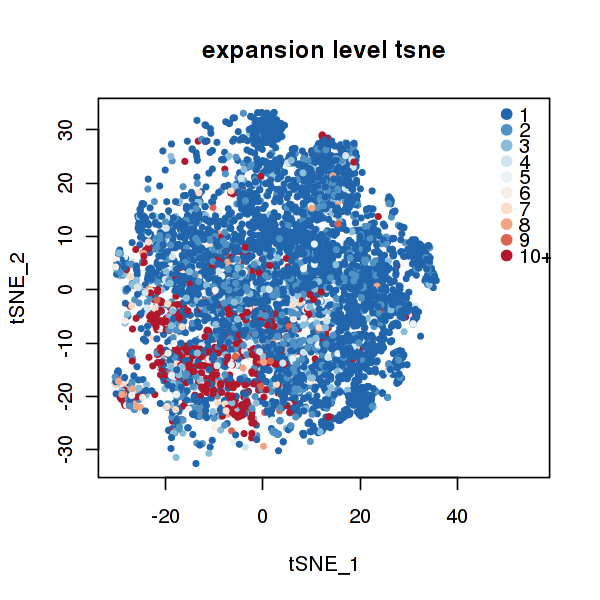

In [66]:
expansion_info_summ=data.table(position_index_matrix[!is.na(position_index_matrix$celltype),c("barcode","expand_lvl")])
expansion_info_summ=expansion_info_summ[,.(expand_lvl=max(expand_lvl)),by=barcode]
expansion_info_summ$expand_lvl[expansion_info_summ$expand_lvl>10]="10+"

source("VDJ_ploting_suite.R")
options(repr.plot.width=5, repr.plot.height=5)
plotByGroup(Exp_Seurat,Group_assignment=expansion_info_summ$expand_lvl[match(colnames(Exp_Seurat@data),expansion_info_summ$barcode)],
            Group_type=c(1:9,"10+"),main="expansion level",tagcol=colorRampPalette(rev(RColorBrewer::brewer.pal(7,"RdBu")))(10)) 

#### CDR3 analysis

##### paired AB analysis?

In [42]:


    batch_info=batch_info[match(rownames(a1),batch_info$batch),]
    a1=data.table(cbind(a1,batch_info))
    b1=a1[,.(count=sum(count),percentage=mean(percentage)),by=patient_id]
    c1=a1[,.(count=sum(count),percentage=mean(percentage)),by=tissue_type]
    d1=a1[,.(count=sum(count),percentage=mean(percentage)),by=disease_status]

    a1_w=data.frame(count=a1$count,percentage=paste0(round(a1$percentage*100,2),"%"))
    rownames(a1_w)=a1$batch_id
    b1_w=data.frame(count=b1$count,percentage=paste0(round(b1$percentage*100,2),"%"))
    rownames(b1_w)=b1$patient_id
    c1_w=data.frame(count=c1$count,percentage=paste0(round(c1$percentage*100,2),"%"))
    rownames(c1_w)=c1$tissue_type
    d1_w=data.frame(count=d1$count,percentage=paste0(round(d1$percentage*100,2),"%"))
    rownames(d1_w)=d1$disease_status

    write.xlsx(data.frame(a1_w), file=paste0(V_id,"_",J_id,"_",C_id,"_stats.xlsx"), sheetName="batch_id", append=T, row.names=T,showNA = T)
    write.xlsx(data.frame(b1_w), file=paste0(V_id,"_",J_id,"_",C_id,"_stats.xlsx"), sheetName="patient_id", append=T, row.names=T,showNA = T)
    write.xlsx(data.frame(c1_w), file=paste0(V_id,"_",J_id,"_",C_id,"_stats.xlsx"), sheetName="tissue_type", append=T, row.names=T,showNA = T)
    write.xlsx(data.frame(d1_w), file=paste0(V_id,"_",J_id,"_",C_id,"_stats.xlsx"), sheetName="disease_status", append=T, row.names=T,showNA = T)



[1] "TRAV1.2_TRAJ33_TRAC"

In [9]:
Exp_Seurat@raw.data=Exp_Seurat@raw.data[,match(colnames(Exp_Seurat@data),colnames(Exp_Seurat@raw.data))]

In [14]:
saveRDS(Exp_Seurat,file="Exp_Seurat_Tcell.Rds")

In [60]:
#cell type assignment
Tcell_assignment_df=data.frame(cluster=c("12,9,5,15","6,16","11","1,0,10,7","14","4,17,3,8,2,13"),
                                  celltype=c("CD8_TEM_effector","CD8","CD8_TCM","NKT","gdT","CD4"),
                                  stringsAsFactors=F)
Tcell_assignment_expanded=cellTypeDF_processing(Tcell_assignment_df)
Tcell_assignment=gp_name_replacing(as.character(Exp_Seurat@ident),Tcell_assignment_expanded$cluster,Tcell_assignment_expanded$celltype)
Tcellsubcelltype_assignment=gp_name_replacing(as.character(Exp_Seurat@ident),Tcell_assignment_expanded$cluster,Tcell_assignment_expanded$subcelltype)


### ancient backup

In [ ]:
spreading_cal=function(tag_patient,tag_tissue,position_index_matrix){
    #spreading cal that has spreadout and spreadin
    #clonetype that expand from one tissue to the other
    expansion_info=list()
    for(i in 1:length(tag_patient)){
        tag=position_index_matrix$patient_id==tag_patient[i] & position_index_matrix$tissue_type %in% tag_tissue
        batch_clontypeid_tbl=table(position_index_matrix$batch[tag],position_index_matrix$clone_id[tag])
        total_cell_perbatch=rowSums(batch_clontypeid_tbl)
        batch_clontypeid_tbl_noexp=batch_clontypeid_tbl[,colSums(batch_clontypeid_tbl)==1]
        batch_clontypeid_tbl=batch_clontypeid_tbl[,colSums(batch_clontypeid_tbl)>1]    #update
        batch_clontypeid_tbl_explocally=batch_clontypeid_tbl[,colSums(batch_clontypeid_tbl>0)==1]
        batch_clontypeid_tbl=batch_clontypeid_tbl[,colSums(batch_clontypeid_tbl>0)>1]    #update
        expansion_info[[i]]=data.frame(batch_id=rownames(batch_clontypeid_tbl_noexp),
                                       no_expansion=rowSums(batch_clontypeid_tbl_noexp),
                                       expanded_locally=rowSums(batch_clontypeid_tbl_explocally),
                                       expanded_spreadout=0,
                                       expanded_spreadin=0)
        if(ncol(batch_clontypeid_tbl)>0){
            batch_clontypeid_percentbybatch_tbl=batch_clontypeid_tbl
            for(j in 1:nrow(batch_clontypeid_tbl)){
                batch_clontypeid_percentbybatch_tbl[j,]=batch_clontypeid_percentbybatch_tbl[j,]/total_cell_perbatch[j]
            }

            for(j in 1:nrow(batch_clontypeid_tbl)){
                expansion_info[[i]]$expanded_spreadout[j]=sum(batch_clontypeid_tbl[j,batch_clontypeid_percentbybatch_tbl[j,]==matrixStats::colMaxs(batch_clontypeid_percentbybatch_tbl)])
                expansion_info[[i]]$expanded_spreadin[j]=sum(batch_clontypeid_tbl[j,batch_clontypeid_percentbybatch_tbl[j,]!=matrixStats::colMaxs(batch_clontypeid_percentbybatch_tbl)])
            }
        }
    }
    expansion_info_tbl=data.table(do.call(rbind,expansion_info))
    expansion_info_tbl_long= melt(expansion_info_tbl, id.vars = c("batch_id"),
                                  measure.vars = c("no_expansion", "expanded_locally", "expanded_spreadout","expanded_spreadin"))
    expansion_info_tbl_long$patient=gsub("_.*","",unique(expansion_info_tbl_long$batch_id))
    expansion_info_tbl_long$tissue=gsub("^.*_","",unique(expansion_info_tbl_long$batch_id))
    return(list(tbl_wide=expansion_info_tbl,tbl_long=expansion_info_tbl_long))
}